# Project 3 Submission, Rev 2
## Wrangle OpenStreetMap Data
### Map Area
Coppell, TX, United States
* https://www.openstreetmap.org/export#map=12/32.9547/-97.0151

This is an area that I am familiar with. I want to explore the database and see what information is available.

## Problems Encountered in the Map

Using the code from the Udacity classroom (Get_sample_map.py), portions of map were investigated for problems by changing the k value.

Upon inspecting the sample map data, following problems were noted:
* Inconsistent street name endings (Blvd/Blvd./Boulevard, Rd/Rd./Road, Ave/Avenue, Dr/Drive, Pkwy/Parkway)
* Inconsistent use of Hwy and Highway for street name values for k="addr:street"
* "k" values have problem character: "." (surface.material)
* Confusing use of E/East, N/North, S/South, W/West when starting street name
* Inconsistent "v" value formats for k="opening_hours" (use of 24 hour time, AM/PM, etc.)
* Inconsistent phone number formats were used in k="phone" (mix of xxx-xxx-xxxx, (xxx)xxx-xxxx, +1-xxx...)
* The values for k="addr:city" included state informaton (e.g., Southlake, TX)
* The values for k= "addr:state" had mix formats including two-letter abbreviation and full state name (e.g., "TX" and "Texas")

## Auditing Data
Each problem identified above has been audited in this section. Before going into each bullet point, number of values for different key types are caculated.

In [216]:
import xml.etree.cElementTree as ET
import re

OSM_PATH = "map_Coppell_TX.osm"  # Input map osm file

# Definitions of key types and stree types
LOWER = re.compile(r'^([a-z]|_)*$')
LOWER_COLON = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
STREET_TYPE_RE = re.compile(r'\b\S+\.?$', re.IGNORECASE)

###
### Helper function to just grab elements "node" and "way"
###

def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

###
### Function to determine key types: lower, lower_colon, problemchars, other
###

def key_type(element, keys):
    
    for tag in element.iter('tag'):    
        if LOWER.search(tag.attrib['k']):
            keys['lower'] += 1
        elif LOWER_COLON.search(tag.attrib['k']):
            keys['lower_colon'] += 1
        elif PROBLEMCHARS.search(tag.attrib['k']):
            keys['problemchars'] += 1
        else:
            keys['other'] += 1     
  
    return keys

# ================================================== #
#                   Audit Data                       #
# ================================================== #

# Check how many values are in each key type.

keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
for element in get_element(OSM_PATH, tags=('node', 'way')):
    keys = key_type(element, keys)
    
print keys

{'problemchars': 2, 'lower': 64763, 'other': 2820, 'lower_colon': 89131}


### Each problem noted has been audited and updated as the following:
* **Inconsistent street name endings (Blvd/Blvd./Boulevard, Rd/Rd./Road, Ave/Avenue, Dr/Drive, Pkwy/Parkway)**
 * All street names ending with abbreviation have been identified and updated with unabbreviated form.
* **Inconsistent use of Hwy and Highway for street name values for k="addr:street"**
 * All street names that contain word "Hwy" are replaced with "Highway"

Below are examples of street names updated by running the function update_name in the submitted python code:

International Pkwy --> International Parkway  
S. Kimball Ave --> S. Kimball Avenue  
Glade Rd --> Glade Road  
Regent Blvd --> Regent Boulevard  
Hwy 121 --> Highway 121  
State Hwy 121 Bypass --> State Highway 121 Bypass

The update_name function utilizes lists and dictionaries the defines expected street name endings, mapping of abbreviated street names to their full name, and words mapping of words list that needs to be updated as below:

In [217]:
# Expected list for street name endings
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons", "Loop", "Freeway", "Way"]

# Mapping to update the street names ending with abbreviation
mapping = { "Ave": "Avenue",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Dr": "Drive",
            "Pkwy": "Parkway",
            "Rd": "Road",
            "Rd.": "Road", 
            "St": "Street",
            "St.": "Street"
           }

# List of words to update
words_list = {'Hwy': 'Highway'}

* **"k" values have problem character: "." (surface.material)**
 * "." character is replace with "_" since it is more consistent with how key values are defined.

There are two instances, which have been update by running python funtion, update_kvalue, in the submitted code:

surface.material --> surface_material

* **Confusing use of E/East, N/North, S/South, W/West when starting street name**
 * All street names starting with E, W, N, S and S. have been fully spelled out

Below are examples of street names updated by running the function, update_EWSN, in the submitted python code:

N Josey Lane --> North Josey Lane  
S. Kimball Ave --> South Kimball Ave  
N Interstate 35E #207 --> North Interstate 35E #207
S. Stemmons Freeway --> South Stemmons Freeway

The function update_EWSN utilized regular expressions to search the stree names:

In [218]:
import re
# Definitions for street names that start with E, W, N, S and S.
START_EAST = re.compile(r'^E\s')
START_WEST = re.compile(r'^W\s')
START_SOUTH = re.compile(r'(^S\s)|(^S.\s)')
START_NORTH = re.compile(r'^N\s')

* **Inconsistent "v" value formats for k="opening_hours" (use of 24 hour time, AM/PM, etc.)**

The values for this key was really messy with different formatting. There are several exceptions, but following formatting policy was enforced where applicable:
 * For daily open hours, i.e., data with "Mo-Su" notation, "Mo-Su" notation was dropped.
 * Replaced all values containing ";" to ",".
 * AM/PM times were converted to 24 hour format.
 * No space before and after "-" that indicates open hour time periods.
 * Consistantly used word "closed" for closed days instead mix of "off" and "closed".

Examples of opening hours updated by running the python function, update_time, are:

05:30 - 20:00 --> 05:30-20:00  
10:00 AM - 9:00 PM --> 10:00-21:00 

* **Inconsistent phone number formats were used in k="phone". (mix of xxx-xxx-xxxx, (xxx)xxx-xxxx, +1-xxx...)**
 * There seems to be no standardized format for storing phone numbers in a database.
 * The country code was dropped. So, all "+1" were dropped.
 * All formats were stripped of separating characters like "-", "()" and space.

Examples of opening hours updated by running the python function, update_phone, are:

Main: (817) 310-5600 Catering: (817) 310-5610 --> Main:8173105600, Catering:8173105610  
+1 972 869 0005 --> 9728690005  
(972) 466-1917 --> 9724661917

* **The values for k="addr:city" included state informaton (e.g., Southlake, TX)**
 * The state information has been removed from the values.
* **The values for k= "addr:state" had mix formats including two-letter abbreviation and full state name (e.g., "TX" and "Texas")**
 * All full name states have been updated to two-letter state abbreviation formats.

_There was one instance the city included state information:_  
Southlake, TX --> Southlake

All state name entries with "Texas" were converted to "TX".

## Import Cleaned Data to CSV File
The audited and cleaned data have been imported to CSV file format using the submitted code: Project3_OpenStreetMap.py

## Data Overview and Additional Thoughts
This section contains basic information about the SQL dataset.
### File sizes
map_Coppell_TX.osm: 51,733 KB  
Coppell_TX_Map.db: 29,167 KB  
nodes.csv: 18,558 KB  
nodes_tags.csv: 291 KB  
ways.csv: 1,507 KB  
ways_nodes.csv: 6,014 KB  
ways_tags.csv: 5,092 KB

### Number of nodes
sqlite> select count(*) from nodes;  
226304

### Number of ways
sqlite> select count(*) from ways;  
25586

### Number of unique users
sqlite> select count(*)  
   ...> from (select uid from nodes union select uid from ways) subs;  
394

### Top 10 contributing users
sqlite> select user, count(*) as num  
   ...> from (select user from nodes union all select user from ways) subs  
   ...> group by user  
   ...> order by num desc  
   ...> limit 10;  
woodpeck_fixbot|71476  
Stephen Sprunk|40096  
dwh1985|16031  
Mara|8131  
WernerP|7764  
brianboru|6116  
Zachy_P|5445  
balrog-kun|4654  
Dranuhl|4212  
tyty5949|4139  

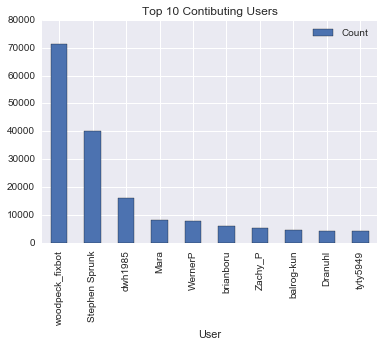

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

db = sqlite3.connect("Coppell_TX_Map.db")
c = db.cursor()
c.execute("select user, count(*) as num \
          from (select user from nodes union all select user from ways) subs \
          group by user \
          order by num desc \
          limit 10;")
result = c.fetchall()
db.close()

user_count_df = pd.DataFrame(result, columns=['User', 'Count'])
user_count_df = user_count_df.set_index('User')

user_count_df.plot.bar(title='Top 10 Contibuting Users')

### Number of users appearing only once
sqlite> select count(*)  
   ...> from (  
   ...> select sub.user, count(*) as num  
   ...> from (select user from nodes union all select user from ways) sub  
   ...> group by sub.user  
   ...> having num = 1) sub1;  
83

* Of all the 251890 contributions from the users, the top three users account for 50.7%.
* The top 10 user contributions account for 66.7%.

### Additional thoughts and suggestions
* The way open hour information provided is not consistent. The original data provided has various notations such as 24/7, Mo-Fr xx:xx-xx:xx, Su closed, etc. This makes it very difficult to search based on open hours. For example, if someone wants to search a coffee store that is open at 6 am, one cannot search efficiently in current database.
* One suggestion is to create tables that stores open day and hour information as the following:  

CREATE TABLE open_days(  
    id INTEGER NOT NULL (references id of the NODE or WAY)  
    Mo TEXT  (yes/no to indicate whether it is open that day)  
    Tu TEXT  
    ...)  

CREATE TABLE open_hours(  
    id INTEGER NOT NULL (references id of the NODE or WAY)  
    day TEXT (references open days in TABLE open_days)  
    00 TEXT (yes/no to indicate whether it is open between 00-01 am)  
    01 TEXT (yes/no to indicate whether it is open between 01-02 am)  
    ...)
    
It will take much work to convert the current informaton to such formats though. Even with the suggestion, store hours that only open and close on the hour will be accurate.
* Another suggestion is to create a table linking the GPS coordinates with zipcodes and/or city. Currently, many data are missing when searching for values (e.g., coffee shops, restaurants, etc) in a particular city. There are 95 instances of place_of_worship in nodes_tags table. However, running the querry below to find out the place_of_worship by city only returned 2 instances.

sqlite> select nodes_tags.value, count(*)  
   ...> from nodes_tags,  
   ...> (select nodes_tags.id from nodes_tags where nodes_tags.value='place_of_worship') sub  
   ...> where nodes_tags.id = sub.id and nodes_tags.key='city';  
Coppell|2

## Additional Data Exploration


### Top 5 most popular cuisine

sqlite> select value, count(*)  
   ...> from (select nodes_tags.value from nodes_tags where nodes_tags.key='cuisine' union all  
   ...> select ways_tags.value from ways_tags where ways_tags.key='cuisine') sub  
   ...> group by value  
   ...> order by count(*) desc  
   ...> limit 5;  
burger|32  
chicken|12  
sandwich|11  
pizza|10  
mexican|8  

          Percent
Cuisine          
burger         32
chicken        12
sandwich       11
pizza          10
mexican         8


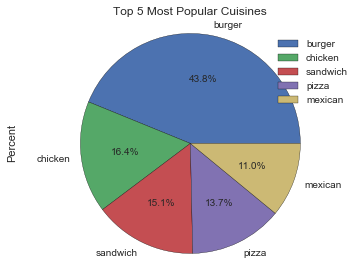

In [18]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

db = sqlite3.connect("Coppell_TX_Map.db")
c = db.cursor()
c.execute("select value, count(*) \
          from (select nodes_tags.value from nodes_tags where nodes_tags.key='cuisine' union all \
          select ways_tags.value from ways_tags where ways_tags.key='cuisine') sub \
          group by value \
          order by count(*) desc \
          limit 5;")
result = c.fetchall()
db.close()

cuisine_df = pd.DataFrame(result, columns=['Cuisine', 'Percent'])
cuisine_df = cuisine_df.set_index('Cuisine')

print cuisine_df

cuisine_df.plot.pie(y = 'Percent', autopct='%.1f%%')
plt.axis('equal')
plt.title('Top 5 Most Popular Cuisines', y=1.05)

### Top 5 amenities

sqlite> select value, count(*) as num  
   ...> from nodes_tags  
   ...> where key='amenity'  
   ...> group by value  
   ...> order by num desc  
   ...> limit 5;  
   
place_of_worship|95  
school|70  
fast_food|55  
restaurant|49  
post_box|24

It was quite surprising that place_of_worship came out at the top.

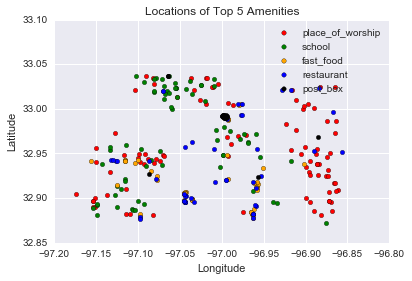

In [24]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

def get_location(val):
    
    querry = "select lat, lon \
        from nodes, nodes_tags \
        where nodes.id=nodes_tags.id and nodes_tags.key='amenity' and nodes_tags.value='{}';".format(val)

    db = sqlite3.connect("Coppell_TX_Map.db")
    c = db.cursor()
    c.execute(querry)
    location = c.fetchall()
    db.close()
    
    return location

def scatter_plot(val, c):
    
    df = pd.DataFrame(location_dict[val])
    df.columns = ['Latitude', 'Longitude']
    pp = df.plot.scatter(x='Longitude', y='Latitude', color=c, label=val, ax=ax)
    
    return pp

list_of_val = ['place_of_worship', 'school', 'fast_food', 'restaurant', 'post_box']
location_dict = {list_of_val[0]:'', list_of_val[1]:'', list_of_val[2]:'', list_of_val[3]:'', list_of_val[4]:''}

for val in list_of_val:
    location_dict[val] = get_location(val)
    
place_of_worship_df = pd.DataFrame(location_dict['place_of_worship'])
place_of_worship_df.columns = ['Latitude', 'Longitude']
ax = place_of_worship_df.plot.scatter(x='Longitude', y='Latitude', color='Red', label='place_of_worship')

scatter_plot('school', 'Green')
scatter_plot('fast_food', 'Orange')
scatter_plot('restaurant', 'Blue')
scatter_plot('post_box', 'Black')
plt.title('Locations of Top 5 Amenities')

### Use of reference materials
I did not use any material other than information or codes from the Udacity lecture, and sample submission provided for SQL.